In [122]:
install.packages('fGarch')

Installing package into ‘/Users/sarthakdasadia/Library/R/3.3/library’
(as ‘lib’ is unspecified)


In [2]:
options(warn=-1)

library(xts)
library(Quandl)
library(dplyr)
library(plotly)
library(lubridate)
library(forecast)
library(TSPred)
library(fGarch)
library(tseries)

### Dowload data using Quandl API

- The API will provide weekly data since 04/08/1990 
- It will form a dataframe which needs to be reversed to in chronological order

In [20]:
qurtly_data = Quandl("CHRIS/CME_NG1", collapse = 'quarterly')
monthly_data = Quandl("CHRIS/CME_NG1", collapse = 'monthly')
weekly_data = Quandl("CHRIS/CME_NG1", collapse = 'weekly')
daily_data = Quandl("CHRIS/CME_NG1", collapse = 'daily')

In [21]:
qurtly_data <- qurtly_data[rev(rownames(qurtly_data)),]
monthly_data <- monthly_data[rev(rownames(monthly_data)),]
weekly_data <- weekly_data[rev(rownames(weekly_data)),]
daily_data <- daily_data[rev(rownames(daily_data)),]

In [22]:
head(weekly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
1423,1990-04-08,1.615,1.635,1.610,1.625,NA,1.625,62,136
1422,1990-04-15,1.595,1.600,1.590,1.598,NA,1.598,40,172
1421,1990-04-22,1.560,1.560,1.540,1.543,NA,1.543,120,174
1420,1990-04-29,1.560,1.560,1.550,1.555,NA,1.555,21,211
1419,1990-05-06,1.570,1.575,1.570,1.575,NA,1.575,9,186
1418,1990-05-13,1.571,1.575,1.565,1.565,NA,1.565,48,167


In [23]:
tail(weekly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
6,2017-06-04,3.051,3.051,2.989,3.004,0.009,2.999,144221,324648
5,2017-06-11,3.034,3.066,3.028,3.044,0.011,3.039,137695,258407
4,2017-06-18,3.049,3.082,3.021,3.028,0.019,3.037,119322,141820
3,2017-06-25,2.898,2.940,2.895,2.921,0.035,2.929,86777,49392
2,2017-07-02,3.037,3.052,2.974,3.041,0.007,3.035,151157,274412
1,2017-07-09,2.949,3.050,2.935,2.950,0.084,2.951,142393,275176


In [24]:
weekly_data <- weekly_data[-1423,]

In [25]:
tail(weekly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
7,2017-05-28,3.186,3.263,3.167,3.252,0.052,3.236,10517,6321
6,2017-06-04,3.051,3.051,2.989,3.004,0.009,2.999,144221,324648
5,2017-06-11,3.034,3.066,3.028,3.044,0.011,3.039,137695,258407
4,2017-06-18,3.049,3.082,3.021,3.028,0.019,3.037,119322,141820
3,2017-06-25,2.898,2.940,2.895,2.921,0.035,2.929,86777,49392
2,2017-07-02,3.037,3.052,2.974,3.041,0.007,3.035,151157,274412


In [26]:
dim(qurtly_data)
dim(monthly_data)
dim(weekly_data)
dim(daily_data)

[1] 110   9

[1] 328   9

[1] 1422    9

[1] 6831    9

In [134]:
p1 <- plot_ly(daily_data, x = ~Date, y = ~Open, type = 'scatter', mode = 'lines') %>%
        layout(title = "Natural Gas Prices Chart",
         xaxis = list(title = "Year"),
         yaxis = list (title = "Price in US$ per Million BTU"))
p1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Convert the dataframe into a time series and check properties

In [27]:
weekly_ts <- ts(weekly_data$Open, frequency=52, start = decimal_date(ymd("1990-04-08")))
#monthly_ts <- ts(log(monthly_data$Open))
#daily_ts <- ts(log(daily_data$Open))

#gas_ts <- ts(log(gas_data$Open), frequency=12, start=decimal_date(ymd("1990-04-30")))

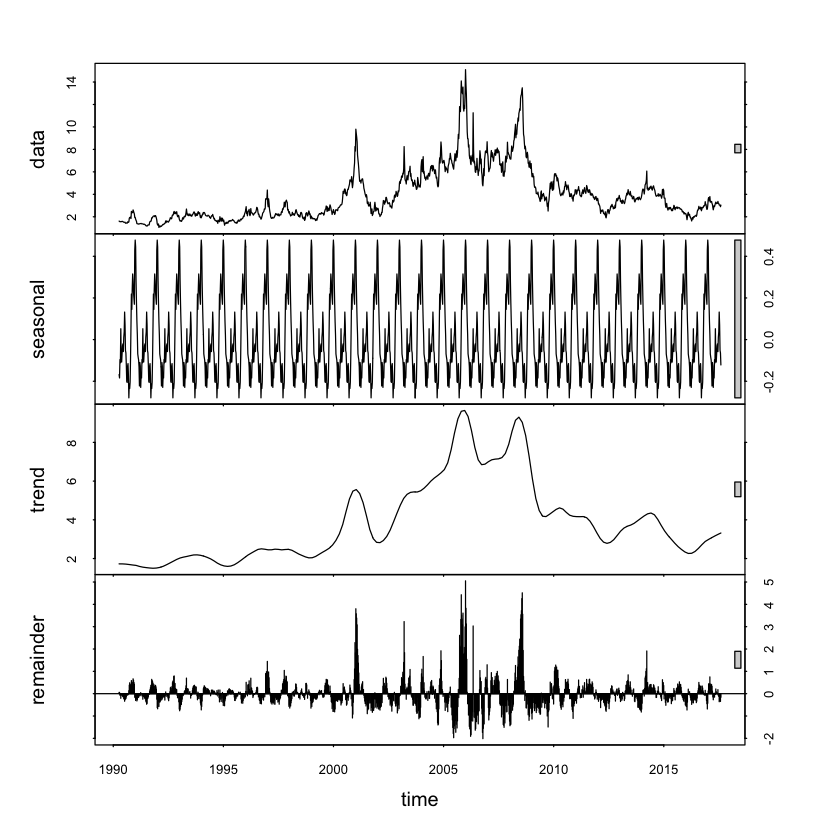

In [28]:
# Decompose time series

decomp = stl(weekly_ts, s.window="periodic")
plot(decomp)

We clearely see seasonality in the residual plot. For Time Series analysis, we need to convert it into a stationary series.

The ***augmented Dickey-Fuller (ADF)*** test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

In [29]:
adf.test(weekly_ts, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  weekly_ts
Dickey-Fuller = -2.8906, Lag order = 11, p-value = 0.2013
alternative hypothesis: stationary


This means that the series is not stationary. Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. 


	Augmented Dickey-Fuller Test

data:  weekly_dff1
Dickey-Fuller = -11.83, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


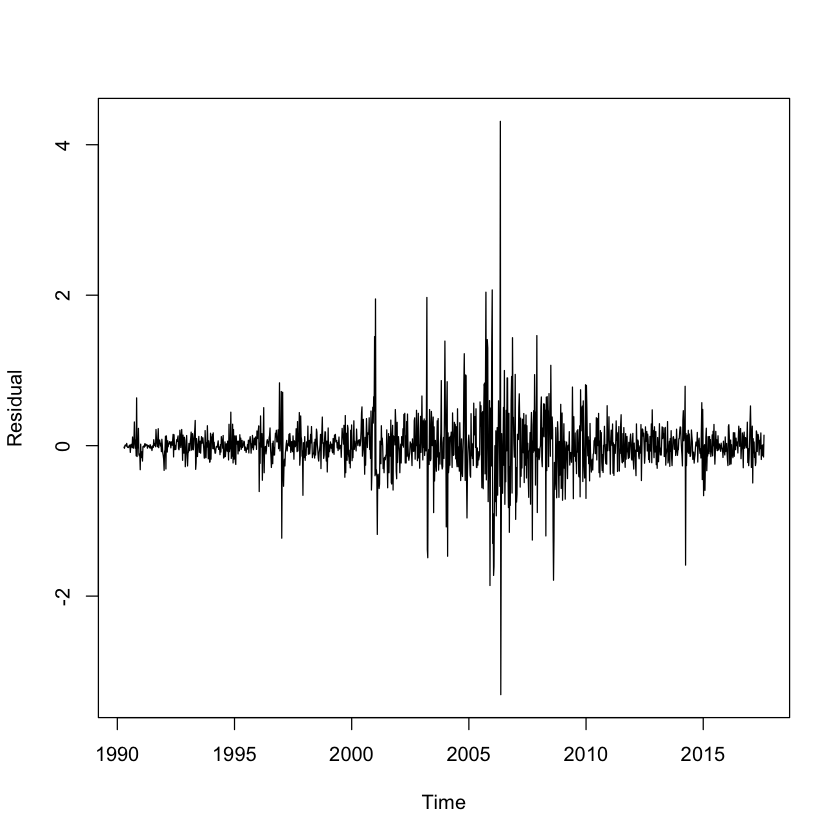

In [30]:
weekly_dff1 = diff(weekly_ts, differences = 1)
adf.test(weekly_dff1, alternative = "stationary")

plot(weekly_dff1, ylab="Residual")

In [31]:
summary(weekly_dff1)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-3.310000 -0.137000  0.000000  0.001001  0.125000  4.311000 

The mean is close to 0 and Dickey-Fuller Test suggests that the null hypothesis can be rejected. That is TS is close to being a stationary and differencing parameter ***d = 1***

*** Autocorrelations and Choosing Model Order ***

Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model. Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

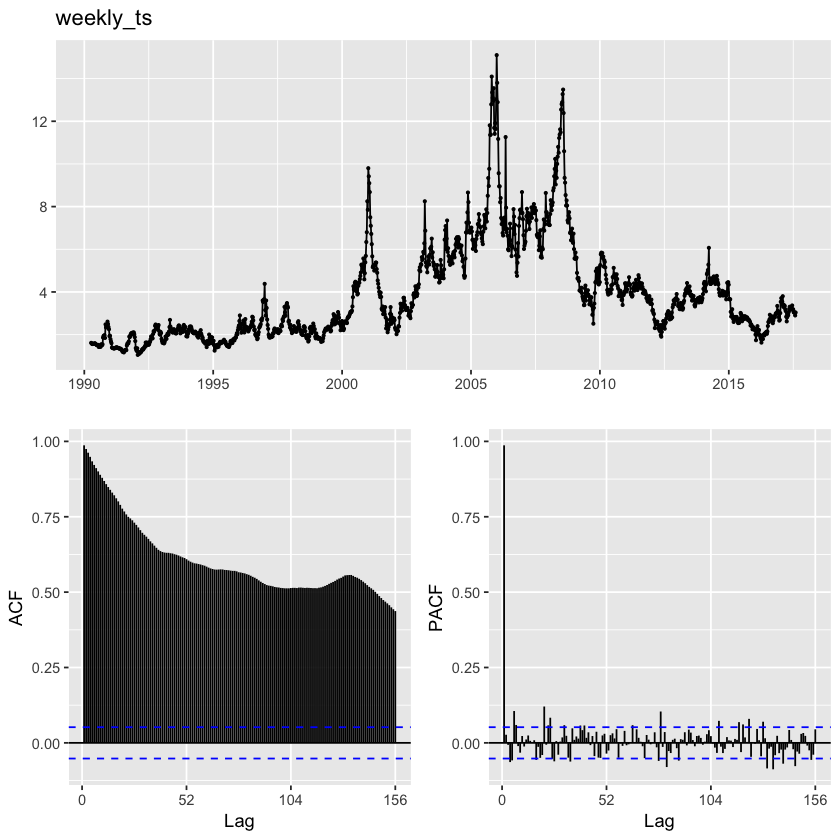

In [32]:
# Inspect ACF and PACF

ggtsdisplay(weekly_ts)

#### Auto-correlation of residual

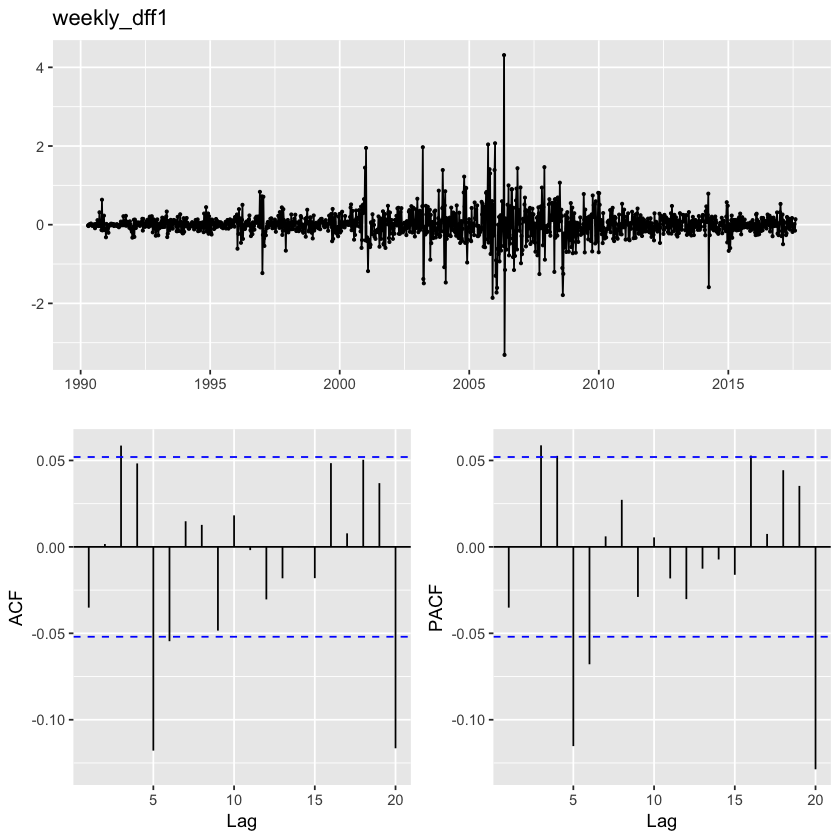

In [44]:
ggtsdisplay(weekly_dff1, lag.max = 20)

There are significant auto correlations at lag 3 and 5 and beyond. Partial correlation plots show a significant spike at lag 3, 5 and 20. This suggests that we might want to test models with AR or MA components of order 3, 5, or 20. 


Call:
arima(x = weekly_ts, order = c(20, 1, 5))

Coefficients:
          ar1     ar2     ar3      ar4      ar5      ar6     ar7     ar8
      -0.2268  0.0138  0.1081  -0.4564  -0.4854  -0.1000  0.0315  0.0754
s.e.   0.3385  0.0993  0.0997   0.1115   0.2566   0.0583  0.0376  0.0372
          ar9     ar10     ar11     ar12     ar13     ar14     ar15    ar16
      -0.0662  -0.0753  -0.0371  -0.0092  -0.0158  -0.0218  -0.0399  0.0305
s.e.   0.0411   0.0494   0.0351   0.0331   0.0326   0.0339   0.0324  0.0309
        ar17    ar18    ar19     ar20     ma1      ma2      ma3     ma4     ma5
      0.0164  0.0582  0.0435  -0.0993  0.1858  -0.0048  -0.0415  0.5464  0.3716
s.e.  0.0355  0.0318  0.0399   0.0357  0.3397   0.1029   0.1021  0.0996  0.2827

sigma^2 estimated as 0.1261:  log likelihood = -545.53,  aic = 1143.05

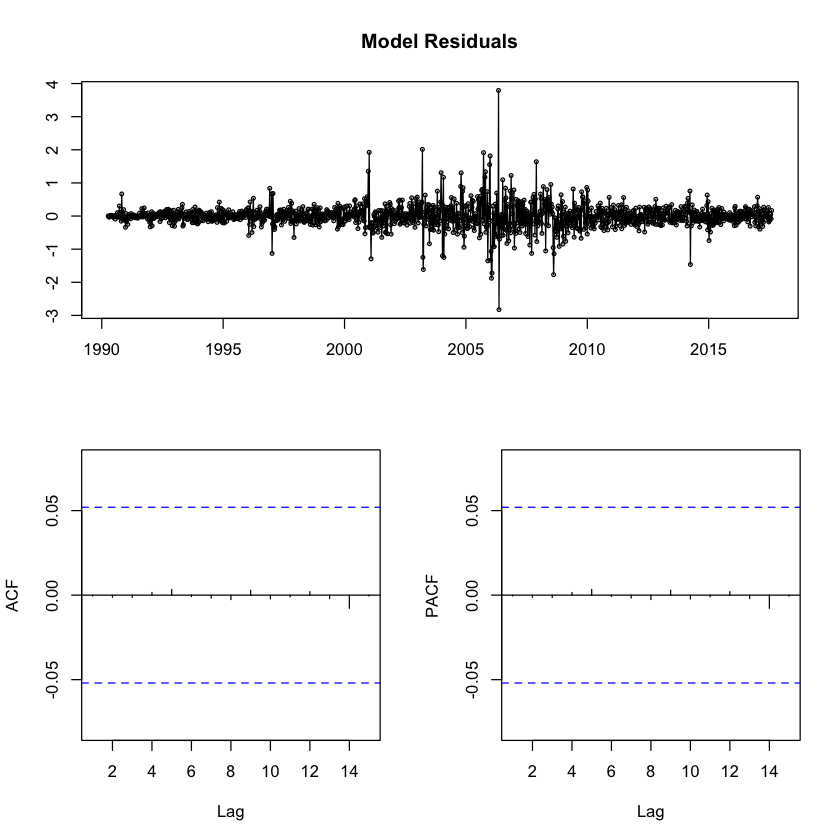

In [45]:
fit_weekly = arima(weekly_ts, order=c(20,1,5))
fit_weekly

tsdisplay(residuals(fit_weekly), lag.max=15, main='Model Residuals')

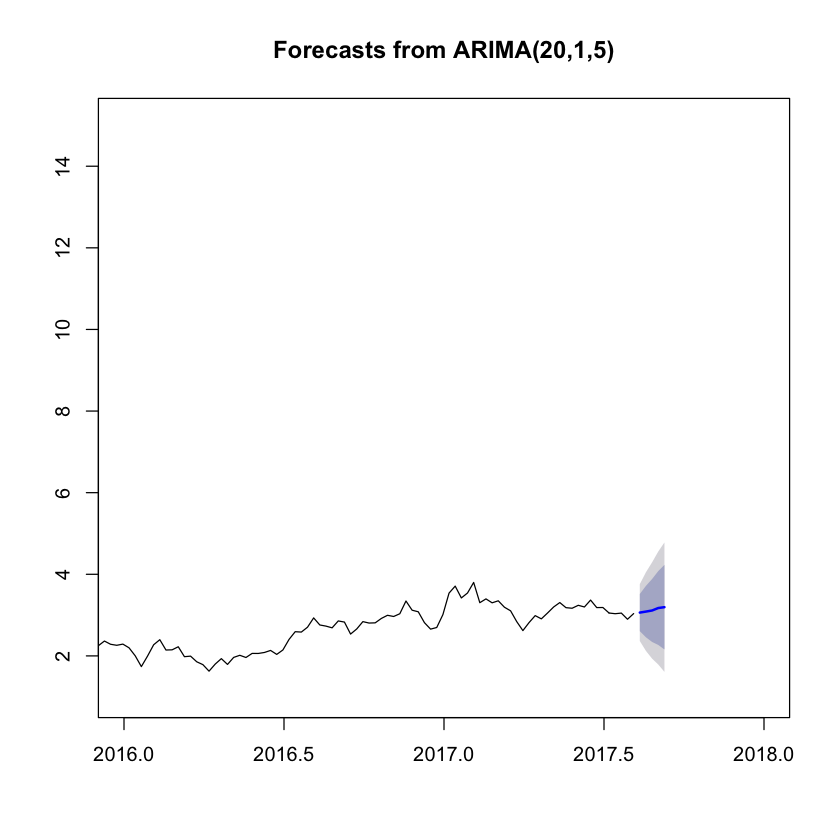

In [46]:
fcast_weekly <- forecast(fit_weekly, h=5)
plot(fcast_weekly, xlim = c(2016,2018))

In [47]:
fcast_weekly

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2017.612       3.061641 2.606587 3.516695 2.365696 3.757586
2017.631       3.086299 2.455792 3.716806 2.122022 4.050576
2017.650       3.112992 2.341418 3.884567 1.932971 4.293013
2017.670       3.173360 2.268416 4.078305 1.789367 4.557354
2017.689       3.194340 2.157757 4.230922 1.609024 4.779656

# Exponential Smoothing

In [49]:
exp_model <- HoltWinters(weekly_ts)

exp_model

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = weekly_ts)

Smoothing parameters:
 alpha: 0.9561109
 beta : 0
 gamma: 0.8383359

Coefficients:
            [,1]
a    3.362557634
b   -0.004222588
s1  -0.331765950
s2  -0.266244896
s3  -0.112591843
s4  -0.016261298
s5   0.021657185
s6   0.005333739
s7   0.135873037
s8   0.239768768
s9   0.283979770
s10  0.361251594
s11  0.363659537
s12  0.558805309
s13  0.568009471
s14  0.725423907
s15  0.772431485
s16  0.788554353
s17  0.787973414
s18  0.750396648
s19  0.656198195
s20  0.693859114
s21  0.477933246
s22  0.283750915
s23  0.051819590
s24 -0.061444348
s25 -0.167979123
s26 -0.240550331
s27 -0.328769497
s28 -0.281928678
s29 -0.279048935
s30 -0.281528282
s31 -0.333038241
s32 -0.209687805
s33 -0.219601216
s34 -0.310527662
s35 -0.195438153
s36 -0.221316464
s37 -0.177973229
s38 -0.227620565
s39 -0.118712093
s40 -0.289567443
s41 -0.301640870
s42 -0.246087934
s43 -0.211138354
s44 -0.240761230
s45 

In [50]:
exp_pred <- predict(exp_model, 5, prediction.interval = TRUE)
exp_pred

fit,upr,lwr
3.026569,3.783929,2.269210
3.087868,4.135695,2.040040
3.237298,4.510990,1.963606
3.329406,4.794548,1.864264
3.363102,4.997419,1.728785


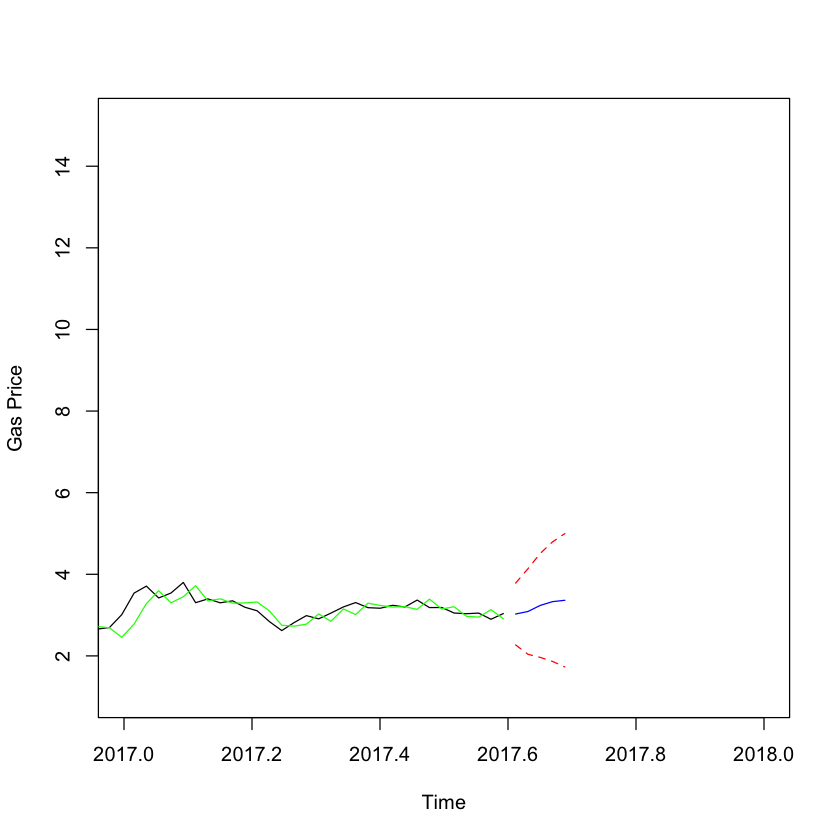

In [53]:
plot.ts(weekly_ts, ylab = "Gas Price", xlim = c(2017, 2018))
lines(exp_model$fitted[,1], col = "green")
lines(exp_pred[,1], col = "blue")
lines(exp_pred[,2], col = "red", lty = 2)
lines(exp_pred[,3], col = "red", lty = 2)